In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import glob
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import ast
import os
dat_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (dat_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(dat_size, d=64e-6)
freq_res = 1/(T_obs*60)
fft_size = len(freq_axis)

2023-07-26 11:53:28.956559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import numpy as np
from scipy.special import fresnel
from math import sqrt, pi, cos, sin, modf, fabs
from scipy.fft import fft, ifft

SQRT2 = sqrt(2)

def gen_z_response(roffset, numbetween, z, numkern):
    absz = fabs(z)
    if absz < 1E-4:
        return gen_r_response(roffset, numbetween, numkern)

    response = np.zeros((numkern, 2)) # A 2D array for complex numbers
    startr = roffset - 0.5 * z
    startroffset = 1.0 + modf(startr)[0] if startr < 0 else modf(startr)[0]
    signz = -1 if z < 0.0 else 1
    zd = signz * SQRT2 / sqrt(absz)
    cons = zd / 2.0
    pibyz = pi / z
    startr += numkern / (2 * numbetween)
    delta = -1.0 / numbetween

    for ii in range(numkern):
        r = startr + ii * delta
        yy = r * zd
        zz = yy + z * zd
        xx = pibyz * r * r
        c = cos(xx)
        s = sin(xx)
        fressy, frescy = fresnel(yy)
        fressz, frescz = fresnel(zz)
        tmprl = signz * (frescz - frescy)
        tmpim = fressy - fressz
        response[ii, 0] = (tmprl * c - tmpim * s) * cons
        response[ii, 1] = -(tmprl * s + tmpim * c) * cons

    if startroffset < 1E-3 and absz < 1E-3:
        zz = z * z
        xx = startroffset * startroffset
        numkernby2 = numkern // 2
        response[numkernby2, 0] = 1.0 - 0.16449340668482264365 * zz
        response[numkernby2, 1] = -0.5235987755982988731 * z
        response[numkernby2, 0] += startroffset * 1.6449340668482264365 * z
        response[numkernby2, 1] += startroffset * (pi - 0.5167712780049970029 * zz)
        response[numkernby2, 0] += xx * (-6.579736267392905746 + 0.9277056288952613070 * zz)
        response[numkernby2, 1] += xx * (3.1006276680299820175 * z)

    return response


def gen_r_response(roffset, numbetween, numkern):
    # Check that the arguments are OK
    if roffset < 0.0 or roffset >= 1.0:
        raise ValueError(f"roffset = {roffset} (out of bounds) in gen_r_response().")

    if numbetween < 1 or numbetween >= 20000:
        raise ValueError(f"numbetween = {numbetween} (out of bounds) in gen_r_response().")

    if numkern < numbetween:
        raise ValueError(f"numkern = {numkern} (out of bounds) in gen_r_response().")

    if numkern % (2 * numbetween) != 0:
        raise ValueError("numkern % (2 * numbetween) != 0 in gen_r_response().")

    # Prep the recursion
    response = np.zeros(numkern, dtype=np.complex_)
    startr = np.pi * (numkern / (2.0 * numbetween) + roffset)
    delta = -np.pi / numbetween
    tmp = np.sin(0.5 * delta)
    alpha = -2.0 * tmp * tmp
    beta = np.sin(delta)
    c = np.cos(startr)
    s = np.sin(startr)

    # Generate the points
    for ii in range(numkern):
        r = startr + ii * delta
        if r == 0.0:
            sinc = 1.0
        else:
            sinc = s / r
        response[ii] = (c * sinc) + 1j * (s * sinc)
        c = alpha * (tmp := c) - beta * s + c
        s = alpha * s + beta * tmp + s

    # Correct for divide by zero when the roffset is close to zero
    if roffset < 1E-3:
        response[numkern // 2] = (1 - 6.579736267392905746 * (tmp := roffset ** 2)) + \
                                 1j * (roffset * (np.pi - 10.335425560099940058 * tmp))

    return response


In [8]:
cur_dir = ''
root_dir = ''
run = 'runBC'
X_train = np.load(cur_dir + f'raw_data/{run}/train_data_chunk.npy').astype(np.float64)
X_test = np.load(cur_dir + f'raw_data/{run}/test_data_chunk.npy').astype(np.float64)
X_val = np.load(cur_dir + f'raw_data/{run}/val_data_chunk.npy').astype(np.float64)
X_train = X_train/np.max(X_train,axis=1)[:,None]
X_test = X_test/np.max(X_test,axis=1)[:,None]
X_val = X_val/np.max(X_val,axis=1)[:,None]

Y_train = np.load(cur_dir + f'raw_data/{run}/train_labels_chunk.npy').astype(np.float64)
Y_test = np.load(cur_dir + f'raw_data/{run}/test_labels_chunk.npy').astype(np.float64)
Y_val = np.load(cur_dir + f'raw_data/{run}/val_labels_chunk.npy').astype(np.float64)


# z_val = Y_val[:,1].copy()
# Y_val[:,0] = Y_val[:,0] - z_val
# Y_val[:,1] = Y_val[:,0] + z_val
# Y_val = np.sort(Y_val,axis=1)

# z_test = Y_test[:,1].copy()
# Y_test[:,0] = Y_test[:,0] - z_test
# Y_test[:,1] = Y_test[:,0] + z_test
# Y_test = np.sort(Y_test,axis=1)

# z_train = Y_train[:,1].copy()
# Y_train[:,0] = Y_train[:,0] - z_train
# Y_train[:,1] = Y_train[:,0] + z_train
# Y_train = np.sort(Y_train,axis=1)

Y_train[:,0] = np.abs(Y_train[:,0])
Y_test[:,0] = np.abs(Y_test[:,0])
Y_val[:,0] = np.abs(Y_val[:,0])

# Y_train[:,1] = 2*np.abs(Y_train[:,1])
# Y_test[:,1] = 2*np.abs(Y_test[:,1])
# Y_val[:,1] = 2*np.abs(Y_val[:,1])

# Y_train = 2*np.abs(Y_train[:,1])
# Y_test = 2*np.abs(Y_test[:,1])
# Y_val = 2*np.abs(Y_val[:,1])

# # Y_train = Y_train/400
# # Y_test = Y_test/400
# # Y_val = Y_val/400

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1) 

Y_train = (Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1))
Y_val = (Y_val.reshape(Y_val.shape[0],Y_val.shape[1], 1))
Y_test = (Y_test.reshape(Y_test.shape[0],Y_test.shape[1], 1))

# Y_train = (Y_train.reshape(Y_train.shape[0],1))
# Y_val = (Y_val.reshape(Y_val.shape[0],1))
# Y_test = (Y_test.reshape(Y_test.shape[0],1))

train_indices = np.load(root_dir + f'raw_data/{run}/train_indices.npy')
test_indices = np.load(root_dir + f'raw_data/{run}/test_indices.npy')
val_indices = np.load(root_dir + f'raw_data/{run}/val_indices.npy')

In [9]:
def match_filter(fft_chunk, roffset, z):
    numkern = len(fft_chunk)
    numbetween = 2
    response = gen_z_response(roffset, numbetween, z, numkern)
    # Fourier transform the response
    fft_chunk = fft(fft_chunk)
    #response_fft = fft(response)

    # Complex conjugate of the response
    #response_fft_conj = np.conj(response_fft)

    # Multiply fft_chunk with the conjugate of the response's Fourier transform
    product = fft_chunk * response

    # Inverse Fourier transform to get the correlation in time domain
    correlation = ifft(product)

    # Get the power (squared absolute value)
    power = np.abs(correlation)**2
    return power

In [5]:
root_dir = ''
run = 'runBD'
labels_df = pd.read_csv(root_dir + f'meta_data/labels_{run}.csv')

In [ ]:
for i in range(100):
    chunk_start = labels_df['chunk_start'].values[train_indices[i]]
    snr = labels_df['snr'].values[train_indices[i]]
    power = match_filter(X_train[i],(chunk_start)/fft_size,Y_train[i,1])
    summed = (power[:,0])**2 + (power[:,1])**2
    print(snr)
    plt.plot(summed)
    plt.axvline(Y_train[i,0],c='r')
    plt.show()
    plt.close()

0.2328828646810111


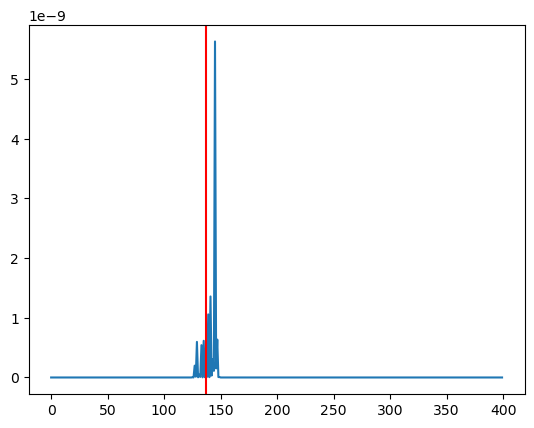

In [11]:
i = 0
chunk_start = labels_df['chunk_start'].values[train_indices[i]]
snr = labels_df['snr'].values[train_indices[i]]
power = match_filter(X_train[i],(chunk_start)/fft_size,Y_train[i,1])
summed = (power[:,0])**2 + (power[:,1])**2
print(snr)
plt.plot(summed)
plt.axvline(Y_train[i,0],c='r')
plt.show()
plt.close()

In [12]:
response = gen_z_response((chunk_start)/fft_size, 2,Y_train[i,1], len(X_train[i]))

In [6]:
labels_df

,Unnamed: 0,Unnamed: 0.1,period,snr,width,bper,binc,bcmass,bphase,ind_orignal,...,pd_pred,p_fold_pred,fold_snr_pred,mismatch_presto,mismatch_pred,mismatch_true,p_max_from_pvol,z_max_from_pvol,z_max_rel_from_pvol,r_max_rel_from_pvol
0,0,0,0.018430,0.009807,17.706850,3.164231,78.639748,1.081535,0.609153,6043,...,NaN,NaN,NaN,0.174603,NaN,0.166667,NaN,NaN,NaN,NaN
1,1,1,0.011389,0.006528,18.177708,3.110412,37.198139,0.917301,0.396721,2966,...,NaN,NaN,NaN,0.090909,NaN,0.015152,NaN,NaN,NaN,NaN
2,2,2,0.001309,0.006974,29.954350,22.327204,24.617172,1.147862,0.876000,9193,...,NaN,NaN,NaN,-0.008333,NaN,0.000000,0.001309,-9.437500,7004.0,1291.0
3,3,3,0.004387,0.002453,14.330613,5.134255,62.075836,0.746256,0.627174,7488,...,NaN,NaN,NaN,-0.160000,NaN,0.120000,0.004364,59.921875,2565.0,2479.0
4,4,4,0.004384,0.006189,18.524147,9.145047,70.641060,1.288268,0.142165,1141153,...,NaN,NaN,NaN,0.036145,NaN,0.012048,0.004382,21.718750,5010.0,1489.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,0.004090,0.006897,13.816407,4.263812,62.972317,0.913363,0.636482,652245,...,-3.490439e-10,0.004088,4.7,NaN,0.440476,0.261905,0.004072,-23.531250,7906.0,2304.0
9996,9996,9996,0.007935,0.006953,27.477110,4.292809,63.933784,0.532522,0.758716,7215,...,NaN,NaN,NaN,0.029703,NaN,0.000000,0.007923,-22.218750,7822.0,1465.0
9997,9997,9997,0.008209,0.009309,28.764847,4.903907,24.496103,0.843452,0.415174,4153,...,NaN,NaN,NaN,0.071895,NaN,-0.013072,0.008199,7.984375,5889.0,1424.0
9998,9998,9998,0.001167,0.009404,19.761496,9.176294,24.863070,0.970899,0.688442,8781,...,NaN,NaN,NaN,0.022599,NaN,0.011299,0.001167,-36.515625,8737.0,1396.0


In [6]:
root_dir = ''
run = 'runBC'
names = []
labels_df = pd.read_csv(root_dir + f'meta_data/labels_{run}.csv')
filenames = labels_df[labels_df['z_max_rel_from_pvol'].isna()]['file_name'].values
for filename in filenames:
    names.append(f'/hercules/results/atya/BinaryML/sims/{run}/pdot_vol/'+filename.replace('.dat','pvol.npy'))

zarray = np.arange(-100.0, 100.0, 4.0/256)
#dr = 1/256
#rarray = np.arange(rint-nr/2*dr, rint+nr/2*dr, 1/256)
for file in names:
    try:
        vol = np.load(file)
        plt.imshow(vol)
        file_name = re.findall(rf'obs\d+{run[3:]}pvol',file)[0]
        labels_df_file = labels_df[labels_df['file_name'] == file_name[:-4]+'.dat']
        index = labels_df_file.index[0]
        p_middle = labels_df_file.loc[index]['p_middle']
        freq_index = (1/p_middle)/freq_res
        z_max_with_r_theory_from_pvol = zarray[-np.argmax(vol[1280,:])]
        max_index = np.argmax(vol)
        z_max, r_max = np.unravel_index(max_index, vol.shape)
        z_max_from_pvol = zarray[-z_max]
        freq_max_from_pvol_ind_neg = freq_index + (r_max - 1280)
        p_max_from_pvol_neg = 1/(freq_max_from_pvol_ind_neg*freq_res)
        print('z_max_with_r_theory_from_pvol: ', z_max_with_r_theory_from_pvol)
        print('z_max_from_pvol: ', z_max_from_pvol)
        print('p_max_from_pvol_neg_diff: ', np.abs(p_max_from_pvol_neg - p_middle))
        print('p_middle: ', p_middle)
        print('actual z', labels_df_file['z'].values[0])
        print('z_max: ', z_max)
        print('r_max: ', r_max)
        print('######################################################################')
        labels_df.at[index,'z_max_from_pvol'] = z_max_from_pvol
        labels_df.at[index,'p_max_from_pvol'] = p_max_from_pvol_neg
        labels_df.loc[index,'z_max_rel_from_pvol'] = z_max
        labels_df.loc[index,'r_max_rel_from_pvol'] = r_max
        plt.savefig(f'raw_data/{run}/pdot_vol_imgs/' + file_name + '.png')
        #plt.scatter(r_max,z_max,c='r')
        #plt.show()
        plt.close() 
    except FileNotFoundError:
        print(file)


z_max_with_r_theory_from_pvol:  62.96875
z_max_from_pvol:  38.625
p_max_from_pvol_neg_diff:  1.2177698212873303e-05
p_middle:  0.009847689477810322
actual z 38.289767722214364
z_max:  3928
r_max:  1415
######################################################################
z_max_with_r_theory_from_pvol:  88.53125
z_max_from_pvol:  48.140625
p_max_from_pvol_neg_diff:  5.715229276982703e-06
p_middle:  0.005762306827769743
actual z 48.49464831965857
z_max:  3319
r_max:  1465
######################################################################
z_max_with_r_theory_from_pvol:  81.109375
z_max_from_pvol:  23.4375
p_max_from_pvol_neg_diff:  6.510017804104047e-07
p_middle:  0.0027718602619027817
actual z 34.25963236672199
z_max:  4900
r_max:  1371
######################################################################
z_max_with_r_theory_from_pvol:  73.40625
z_max_from_pvol:  -41.890625
p_max_from_pvol_neg_diff:  4.921445950924804e-06
p_middle:  0.003279743124823885
actual z -49.89845957133325


In [8]:
labels_df[labels_df['z_max_rel_from_pvol'].isna()]

,Unnamed: 0,period,snr,width,bper,binc,bcmass,bphase,z,# ind,...,mismatch_pred,mismatch_true,mismatch_presto_ACCEL_1200,a_presto_ACCEL_1200,z_presto_ACCEL_1200,p_max_from_pvol,z_max_from_pvol,r_max,z_max_rel_from_pvol,r_max_rel_from_pvol


In [7]:
labels_df

,Unnamed: 0,Unnamed: 0.1,period,snr,width,bper,binc,bcmass,bphase,ind_orignal,...,pd_pred,p_fold_pred,fold_snr_pred,mismatch_presto,mismatch_pred,mismatch_true,p_max_from_pvol,z_max_from_pvol,z_max_rel_from_pvol,r_max_rel_from_pvol
0,0,0,0.018430,0.009807,17.706850,3.164231,78.639748,1.081535,0.609153,6043,...,NaN,NaN,NaN,0.174603,NaN,0.166667,0.018375,-10.187500,NaN,NaN
1,1,1,0.011389,0.006528,18.177708,3.110412,37.198139,0.917301,0.396721,2966,...,NaN,NaN,NaN,0.090909,NaN,0.015152,0.011369,20.875000,NaN,NaN
23,23,23,0.009578,0.002729,27.184132,16.678955,62.018837,0.201700,0.623529,5013,...,NaN,NaN,NaN,-0.404255,NaN,0.063830,0.009574,-0.171875,NaN,NaN
2342,2342,2342,0.007488,0.008144,12.408456,8.135245,78.242622,1.122884,0.895086,732697,...,-8.175272e-10,0.007491,4.7,-0.043478,0.48913,0.010870,0.007484,-13.250000,NaN,NaN
2351,2351,2351,0.019453,0.004802,25.784948,5.506998,43.532631,1.324485,0.800428,1984765,...,NaN,NaN,NaN,0.052632,NaN,0.035088,0.019451,-9.984375,NaN,NaN
2979,2979,2979,0.019174,0.003582,29.196440,7.806665,62.726517,0.621326,0.317515,1335812,...,NaN,NaN,NaN,0.076923,NaN,0.153846,0.019124,3.890625,NaN,NaN
3028,3028,3028,0.018311,0.006931,17.757687,5.185500,72.536880,1.090662,0.327697,913991,...,NaN,NaN,NaN,0.024390,NaN,-0.036585,0.018240,13.953125,NaN,NaN
9943,9943,9943,0.010405,0.004519,28.835026,3.490530,83.751129,0.649617,0.789721,1678441,...,NaN,NaN,NaN,-0.538462,NaN,-0.153846,0.010407,-31.296875,NaN,NaN
9945,9945,9945,0.002856,0.004036,23.791763,6.516517,33.987759,1.154806,0.647291,7838,...,NaN,NaN,NaN,-0.034483,NaN,0.137931,0.002848,38.468750,NaN,NaN


In [9]:
labels_df.to_csv('meta_data/labels_runBC.csv')

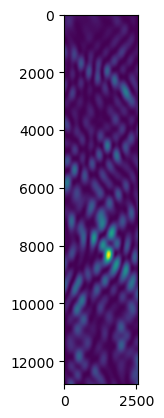

In [8]:
#plot a 2d array
#plt.imshow(vol[16384//2-400:16384//2+400,16384//2-400:16384//2+400])
plt.imshow(vol)

In [28]:
names = glob.glob(f'/hercules/results/atya/BinaryML/sims/runBD/pdot_vol/*.npy')

In [29]:
names[0]

'/hercules/results/atya/BinaryML/sims/runBD/pdot_vol/obs3701BDpvol.npy'

In [9]:
vol = np.load(f'/hercules/results/atya/BinaryML/sims/runBD/pdot_vol/obs3701BDpvol.npy')

In [10]:
# Find the indices of the maximum value in the entire array
max_index = np.argmax(vol)
max_row_index, max_col_index = np.unravel_index(max_index, vol.shape)

In [14]:
P_z = vol[:,max_col_index]
P_z_max = np.max(P_z)
P_z_min = np.min(P_z)
#P_z = -P_z + P_z_min
def physics_loss(y_true, y_pred):
    z_ind_pred = np.argmin(np.abs(zarray - y_pred))
    return 1 - P_z[z_ind_pred]/P_z_max
def loss_function(y_true, y_pred):
    lamb = 10000
    return lamb*physics_loss(y_true, y_pred)

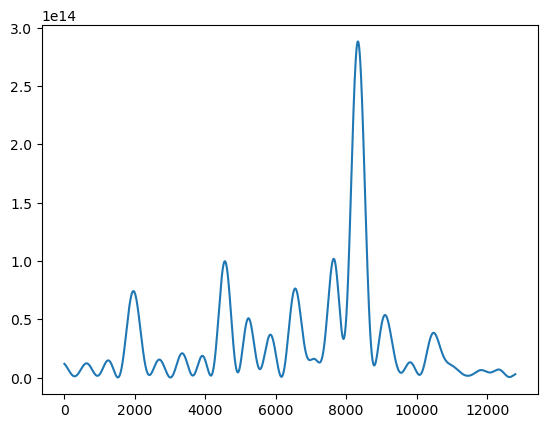

In [15]:
plt.plot(P_z)

In [23]:
zarray = np.arange(100.0, -100.0, -4.0/256)

In [7]:
len(zarray)

12800

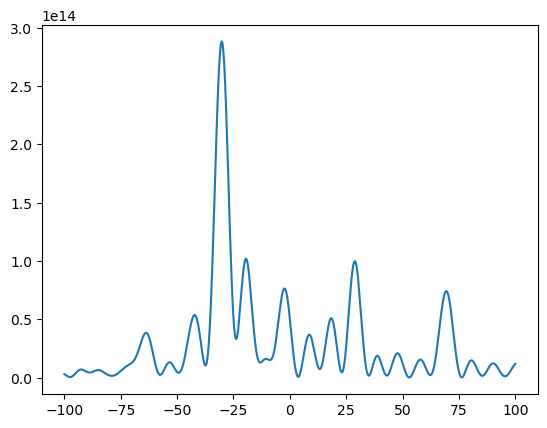

In [17]:
plt.plot(zarray,vol[:,max_col_index])

In [18]:
loss_all = []
for z in zarray:
    loss_all.append(loss_function(-29.65, z))

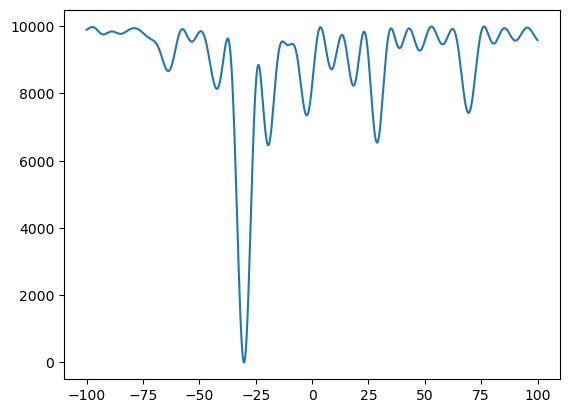

In [19]:
plt.plot(zarray,loss_all)

In [87]:
zarray = np.load('random_dir/zarray.npy')

In [88]:
zarray[-5064]

20.875

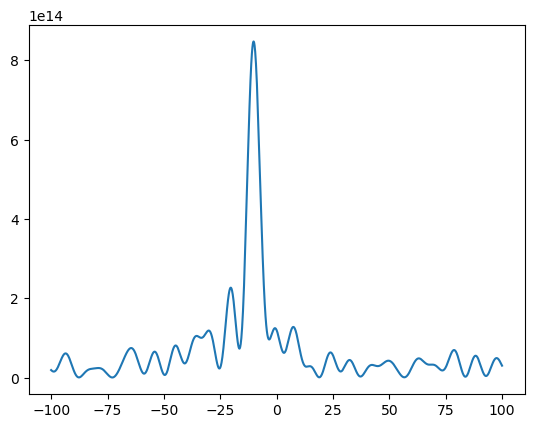

In [80]:
# reverse zarray
zarray = zarray[::-1]
plt.plot(zarray,vol[:,12930])

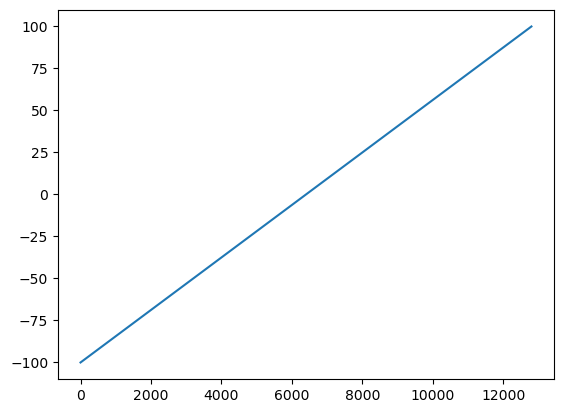

In [19]:
plt.plot(zarray)

In [2]:
labels_df = pd.read_csv('meta_data/labels_runBC.csv')

In [3]:
labels_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'period', 'snr', 'width', 'bper', 'binc',
       'bcmass', 'bphase', 'z', '# ind', 'a', 'p_middle', 'pd', 'a_max',
       'z_max', 'p_fold', 'asini', 'periastron_time_mjd', 'file_name',
       'chunk_start', 'presto_nearest_period_accel_1200',
       'presto_nearest_cand_num_accel_1200', 'fold_snr_presto_ACCEL_1200',
       'p_presto_ACCEL_1200', 'pd_presto_ACCEL_1200', 'p_pred', 'z_pred',
       'a_pred', 'pd_pred', 'p_fold_pred', 'status', 'fold_snr_pred',
       'fold_snr_thoery', 'fold_snr_true', 'mismatch_pred', 'mismatch_true',
       'mismatch_presto_ACCEL_1200', 'a_presto_ACCEL_1200',
       'z_presto_ACCEL_1200', 'p_max_from_pvol', 'z_max_from_pvol', 'r_max',
       'z_max_rel_from_pvol', 'r_max_rel_from_pvol'],
      dtype='object')

In [5]:
labels_df[labels_df['z_max_rel_from_pvol'].isna()]

,Unnamed: 0,Unnamed: 0.1,period,snr,width,bper,binc,bcmass,bphase,z,...,mismatch_pred,mismatch_true,mismatch_presto_ACCEL_1200,a_presto_ACCEL_1200,z_presto_ACCEL_1200,p_max_from_pvol,z_max_from_pvol,r_max,z_max_rel_from_pvol,r_max_rel_from_pvol


In [5]:
root_dir = ''
run = 'runBC'
type = 'train'
labels_df = pd.read_csv(root_dir + f'meta_data/labels_{run}.csv')
indices = np.load(f'raw_data/{run}/{type}_indices.npy')

vol_zslice = np.zeros((len(indices),12800))

zarray = np.arange(-100.0, 100.0, 4.0/256)
#dr = 1/256
#rarray = np.arange(rint-nr/2*dr, rint+nr/2*dr, 1/256)
for i,index in enumerate(indices):
    try:
        file_name = labels_df.loc[index]['file_name']
        vol_file_name = f'/hercules/results/atya/BinaryML/sims/{run}/pdot_vol/'+file_name.replace('.dat','pvol.npy')
        vol = np.load(vol_file_name)
        z_max = labels_df.loc[index]['z_max_rel_from_pvol']
        r_max = labels_df.loc[index]['r_max_rel_from_pvol']
        z_slice = vol[:,int(r_max)]
        vol_zslice[i,:] = z_slice
    except FileNotFoundError:
        print(file)
np.save(f'raw_data/{run}/{type}_rslices.npy',vol_zslice)

In [4]:
zarray = np.arange(200.0, -200.0, -8.0/256)

In [ ]:
def find_z_ind(z_array,z_value):
    return np.argmin(np.abs(z_array-z_value))

def loss_function(y_true,y_pred):
    lamb = 1.0
    if y_pred>200:
        return (y_true - y_pred)**2
    else:
        return 1 - lamb*rslices[find_z_ind(y_true_array,y_true),find_z_ind(zarray,y_pred)]/max_r_slice[find_z_ind(zarray,y_pred)]

In [ ]:
import tensorflow as tf

def find_z_ind(z_array, z_value):
    return tf.argmin(tf.abs(z_array - z_value), axis=-1)

def loss_pvol_calc(y_true_index_in_original_dataset,y_pred_index_in_z_array,rslices,max_r_slice):
    
    1 - tf.gather(rslices,[y_true_index_in_original_dataset,y_pred_index_in_z_array], axis=-1)/tf.gather(max_r_slice, y_true_index_in_original_dataset, axis=-1)

def loss_function(y_true, y_pred, rslices, y_true_array, zarray, max_r_slice):
    lamb = 1.0
    y_true_index_in_original_dataset_list = tf.map_fn(lambda y: find_z_ind(y_true_array, y), y_true, dtype=tf.int64)
    y_pred_index_in_z_array_list = tf.map_fn(lambda y: find_z_ind(zarray, y), y_pred, dtype=tf.int64)
    
    loss1 = tf.square(y_true - y_pred)
    loss2 = tf.map_fn(lambda [ind_y, ind_z]: loss_pvol_calc(ind_y,ind_z,rslices,max_r_slice),
                    y_true_index_in_original_dataset_list,
                    y_pred_index_in_z_array_list,
                        dtype = tf.float64    )
    
    # Use tf.reduce_mean to average the loss over the batch
    return tf.reduce_mean(tf.where(y_pred > 200, loss1, loss2))


In [ ]:
import tensorflow as tf

def find_index(array, value):
    return tf.argmin(tf.abs(array - value), axis=-1)

def calc_loss(index_true, index_pred, slices, max_slice, lambda_):
    return lambda_*(1 - tf.gather(slices, [index_true, index_pred], axis=-1) / tf.gather(max_slice, index_true, axis=-1))

def loss_function(true, pred, slices, true_array, array, max_slice):
    lambda_ = 1.0
    index_true_list = tf.map_fn(lambda y: find_index(true_array, y), true, dtype=tf.int64)
    index_pred_list = tf.map_fn(lambda y: find_index(array, y), pred, dtype=tf.int64)
    
    loss1 = tf.square(true - pred)
    
    # Pack the indices together into pairs
    indices = tf.stack([index_true_list, index_pred_list], axis=1)
    
    # Apply calc_loss to each pair of indices
    loss2 = tf.map_fn(lambda index_pair: calc_loss(index_pair[0], index_pair[1], slices, max_slice, lambda_), indices, dtype=tf.float64)
    
    return tf.reduce_mean(tf.where(pred > 200, loss1, loss2))


In [7]:
np.max(vol_zslice,axis=1).shape

(6306,)